<a href="https://colab.research.google.com/github/Varshini-R/Deep-Belief-Network/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/2015xli/DBN.git

Cloning into 'DBN'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 71 (delta 1), reused 5 (delta 1), pack-reused 63
Unpacking objects: 100% (71/71), done.


In [ ]:
from keras.datasets import mnist

In [10]:
from IPython.core.debugger import set_trace

%run "activation.ipynb"
import numpy as np
import pickle

%run "mnist.ipynb"
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid

class RBM:
    
    def __init__(self, n_v, n_h, W=None, b=None, c=None, k=1):
        assert n_v != 0 and n_h != 0
        self.n_v = n_v
        self.n_h = n_h
        shape = (n_h, n_v)
        
        self.W = W if W is not None else np.random.uniform(-1, 1, size=shape)
        self.b = b if b is not None else np.zeros(n_v)
        self.c = c if c is not None else np.zeros(n_h)

        assert self.W.shape==shape and n_v == len(self.b) and n_h == len(self.c)
        
        self.k = k
        self.training_done = True if W is not None and b is not None and c is not None else False
        return
        
    def forward(self, V):
        n_sample, n_v = V.shape
        
        hsignal = np.dot(V, self.W.T) + self.c
        assert hsignal.shape == (n_sample, self.n_h)
        Hp = sigmoid(hsignal)
        
        #s = np.random.uniform(0, 1, size=hsignal.shape)
        #Hs = (s < Hp) * 1  # same as:
        Hs = np.random.binomial(1, Hp, size=Hp.shape)
        return Hp, Hs
    
    def backward(self, H):
        n_sample, n_h = H.shape
        
        vsignal = np.dot(H, self.W) + self.b
        assert vsignal.shape == (n_sample, self.n_v)
        #print(vsignal)
        Vp = sigmoid(vsignal)
        
        s = np.random.uniform(0, 1, size=vsignal.shape)
        Vs = (s < Vp) * 1
        return Vp, Vs

    def gibbs(self, V):  #return (probability, samples) of visible units
        Vs = V
        for i in range(self.k):
            Hp, Hs = self.forward(Vs)
            Vp, Vs = self.backward(Hs)
            
        return Hp, Hs, Vp, Vs
    
    def contrastive_divergence(self, V, learning=0.01):
        #set_trace()
        n_sample, n_v = V.shape
        
        Vs = V
        Hp, Hs, Vp_, Vs_ = self.gibbs(Vs)   # underscore _ refers to tilde for negative sample
        Hp_, Hs_ = self.forward(Vs_)

        Vs1 = np.mean(Vs, axis=0) 
        Vs2 = np.mean(Vs_, axis=0) 
        Hp1 = np.mean(Hp, axis=0)
        Hp2 = np.mean(Hp_, axis=0)
        Hs1 = np.mean(Hs, axis=0)
        Hs2 = np.mean(Hs_, axis=0)
        
        # note, there are variances in how to compute the gradients.
        # Hugo suggests:     h(v1)*v1 - h(v2)*v2
        # Bengio suggests:   h1*v1 - h(v2)*v2
        # My derivation:     h1(v1)*v1 - h2*v2 
        
        Eh_b = Vs1; Evh_b = Vs2      # Evh_b refers to the Expectation (over v and h) of -logP(v) gradient wrt b
        
        #Eh_c = Hs1; Evh_c = Hp2  # bengio
        Eh_c = Hp1; Evh_c = Hp2  # hugo
        #Eh_c = Hp1; Evh_c = Hs2  # Mine

        g_b = Evh_b - Eh_b  # gradient of -logP(v) wrt b
        g_c = Evh_c - Eh_c

        Eh_W = np.outer(Eh_c, Eh_b) 
        Evh_W = np.outer(Evh_c, Evh_b)
        g_W = Evh_W - Eh_W
    
        self.W -= g_W * learning
        self.b -= g_b * learning
        self.c -= g_c * learning        
        return
    
    def reconstruct(self, V):
        Hp, Hs = self.forward(V)
        Vp, Vs = self.backward(Hp)
        return Vp, Vs

    # this is the API for app to use
    def train(self, X, n_epoch=1, batch_size=10, learning=0.01, save_file=None):
        if self.training_done: return
        
        save_file += ".rbm"
        self.train_model(X, n_epoch, batch_size, learning, save_file)
        
        self.training_done = True
        return
    
    # this is the API for more complex network to use
    def train_model(self, X, n_epoch=1, batch_size=10, learning=0.01, save_file=None):
        
        batch_size = batch_size if batch_size > 0 else 10
        n_epoch = n_epoch if n_epoch > 0 else 1
        n_sample = X.shape[0]
        n_batch = n_sample//batch_size
        for i in range(n_epoch):
            for j in range(n_batch):
                s = j*batch_size
                V = X[s:s+batch_size]
                self.contrastive_divergence(V, learning)

        self.save_model(save_file + ".epochs" + str(n_epoch))
        return


    def save_model(self, save_file):
        dict = {'n_v':self.n_v, 'n_h':self.n_h, 'W':self.W, 'b':self.b, 'c':self.c}

        save_file += "."+ str(self.n_v) + "x" + str(self.n_h)
        with open(save_file, 'wb') as f:
            pickle.dump(dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        return

    @classmethod
    def load_model(clazz, model_file):
        with open(model_file, 'rb') as f:
            m = pickle.load(f)

        rbm = RBM(m['n_v'], m['n_h'], m['W'], m['b'], m['c'])
        return rbm
    
    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.W)
        minw = np.amin(self.W)
        count = self.n_h if count == -1 or count > self.n_h else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.W[i] if i<self.n_h else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        #fig.suptitle(suptitle, size=20)
        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        #fig.subplots_adjust(top=0.85 + nrows*0.002)    #adjust suptitle position
        plt.show()
        return

In [11]:
# testing of the RBM code above

class MNIST_RBM:

    def __init__(self, n_v, n_h, load_file=None, save_file="mnist", data_path="/content/convolution-network"):
        if load_file is None: 
            self.rbm = RBM(n_v, n_h)
        else:
            self.rbm = RBM.load_model(load_file)
        
        self.train_input = MnistInput("train", data_path)
        self.test_input = MnistInput("test", data_path)


    def train(self, train_size=-1, n_epoch=100, batch_size=10, learning=0.01):
        if self.rbm.training_done: return
        
        X = []
        n_x = 0
        for x, y in self.train_input.read(train_size):
            X.append(x)
            n_x += 1

        X = np.array(X).reshape(n_x, -1) > 30
        X = X*1
        
        self.rbm.train(X, n_epoch, batch_size, learning, save_file="mnist")
        return

    def test_reconstruct(self, n):
        X=[]; i=2*n
        for x, y in self.test_input.read(n):
            x *= np.random.binomial(1, i/(n*2), size=(28,28))
            x = x * 2*n/i
            X.append(x)
            i -=1

        ncols = 10
        nrows = int(n/5)
        fig = plt.figure(figsize=(ncols, nrows), dpi=300)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,10))

        for i, ax in enumerate(grid):
            j = i//2
            if i%2 == 0:
                ax.imshow(X[j].reshape(28,28), cmap=mpl.cm.Greys)
                if i<ncols:
                    ax.set_title("Original")
            else:
                Vp, Vs = self.rbm.reconstruct(X[j].reshape(1, -1)/255)
                ax.imshow(Vp.reshape(28,28), cmap=mpl.cm.Greys)
                if i<ncols:
                    ax.set_title("Reconst.")

            ax.set_axis_off()

        fig.suptitle('Original and reconstructed digits side by side')
        fig.tight_layout()
        fig.subplots_adjust(top=0.80)    
        plt.show()        
        return

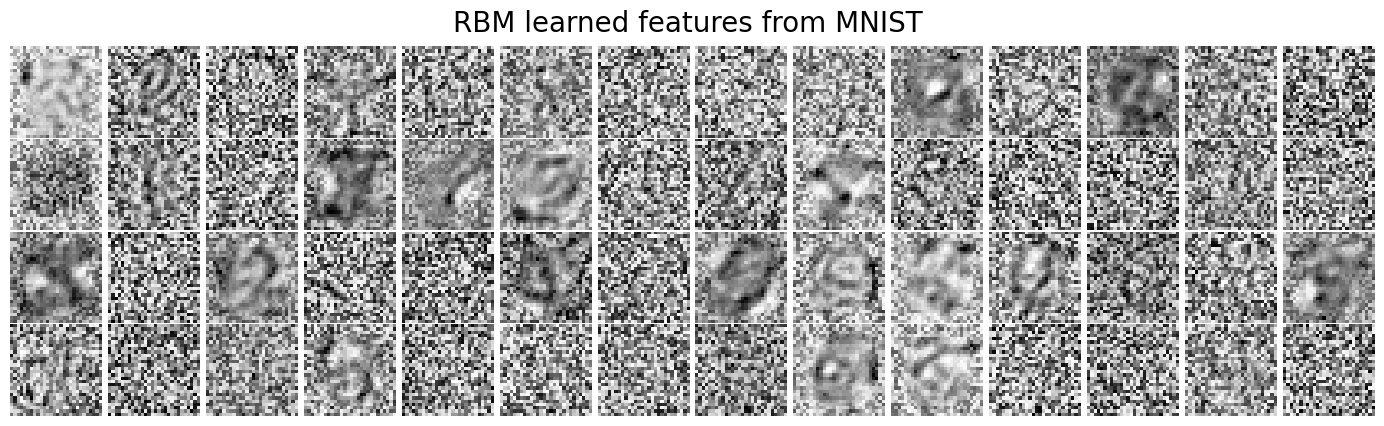

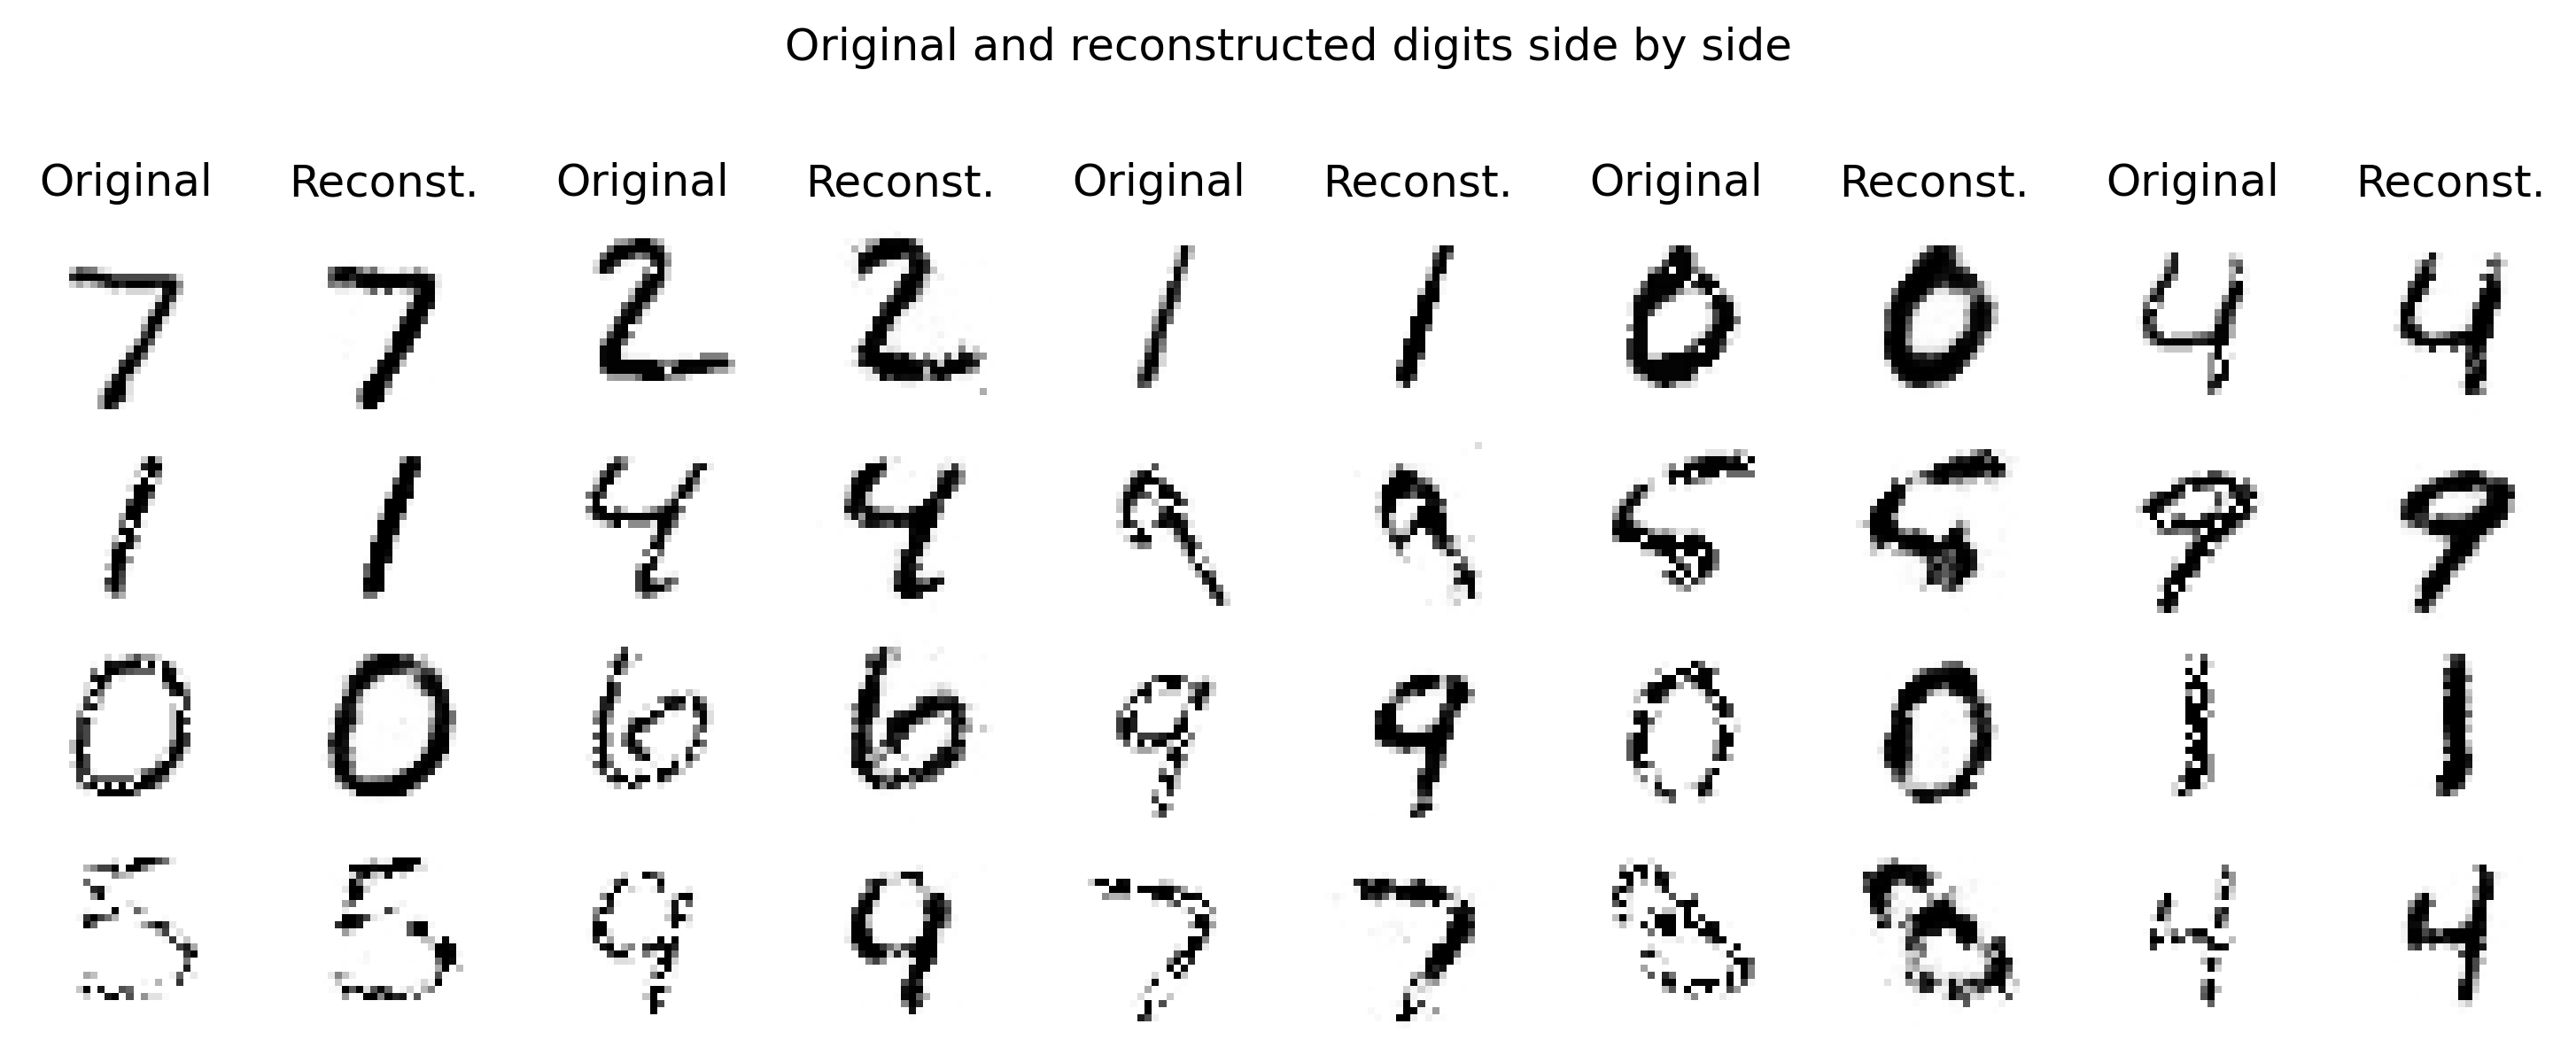

In [12]:
mnist_rbm = None
if __name__ == "__main__" and '__file__' not in globals():
    
    np.seterr(all='raise')
    plt.close('all')
    model_file = "/content/DBN/trained_models/mnist_rbm.784x500.epochs100"
    mnist_rbm = MNIST_RBM(28*28, 500, model_file)
    #mnist_rbm = MNIST_RBM(28*28, 500, load_file=None)
    mnist_rbm.train(1000, n_epoch=1, batch_size=10)
    mnist_rbm.rbm.show_features((28,28), "RBM learned features from MNIST ", 56)
    mnist_rbm.test_reconstruct(20)

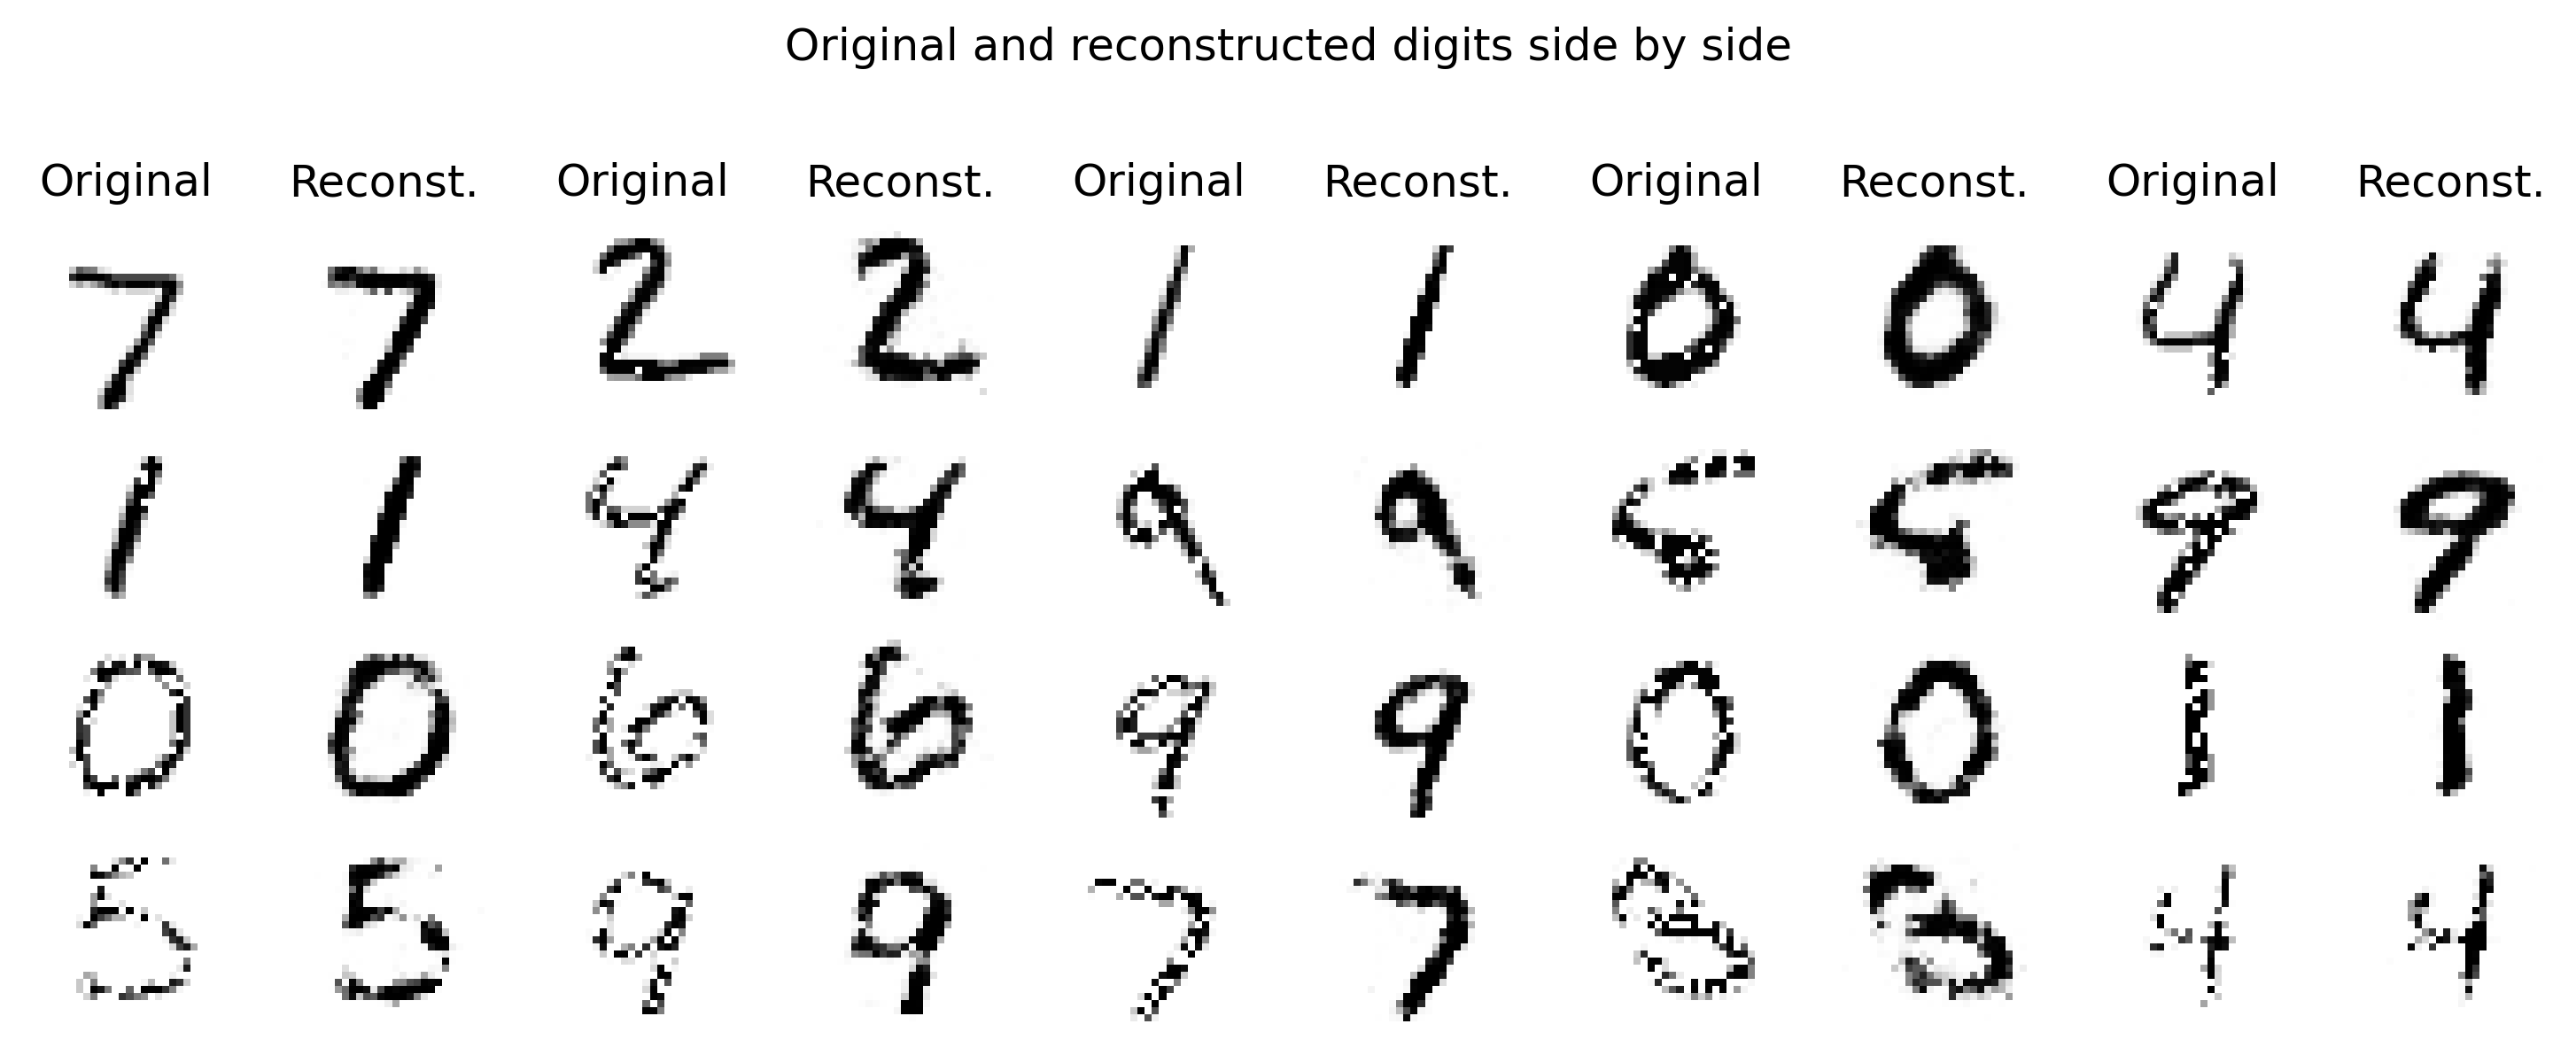

In [13]:
if __name__ == "__main__" and '__file__' not in globals():
    model_file = "/content/DBN/trained_models/mnist_rbm.784x500.epochs100"
    rbm = MNIST_RBM(None,None,model_file)
    #rbm.show_features()
    rbm.test_reconstruct(20)